In [160]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from graphviz import Digraph
%matplotlib inline

In [161]:
class Value:

    def __init__(self, data: float, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward(): 
            self.grad += 1.0 * out.grad # += instead of = 
            other.grad += 1.0 * out.grad # due to multivariable case of duplicate variables

        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') # we always create new objects for the graph to visualize properly

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self
        return self * other # we don't need a label to return this because __mul__ already does that
        # we just redirect it to the correct order
        # we pass in this since we know that self is for sure a value object
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        assert other != 0, "exponent cannot be 0"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad # assuming that other != 0
        out._backward = _backward

        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __rtruediv__(self, other):
        return other * self**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other) # there is no need for a gradient function here because it builds automatically from + and *
    
    def __rsub__(self, other): # other - self
        return (-self) + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-(t**2)) * out.grad # note t = out.data

        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) 
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [162]:
def trace(root):
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))

        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = "record")

        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


# backprop via a neuron

In [163]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()

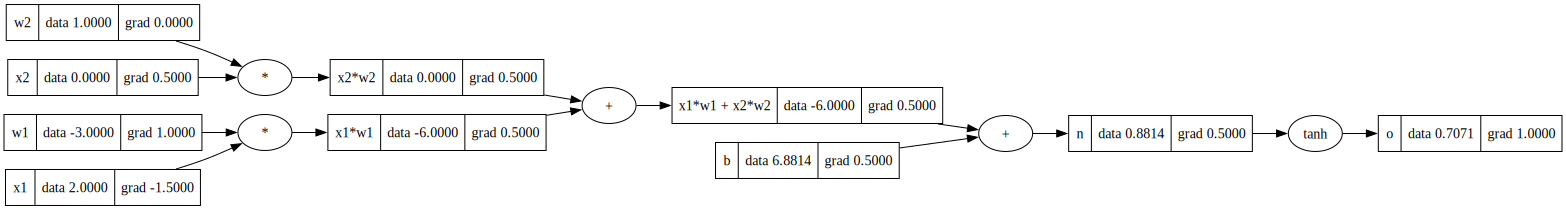

In [164]:
draw_dot(o)

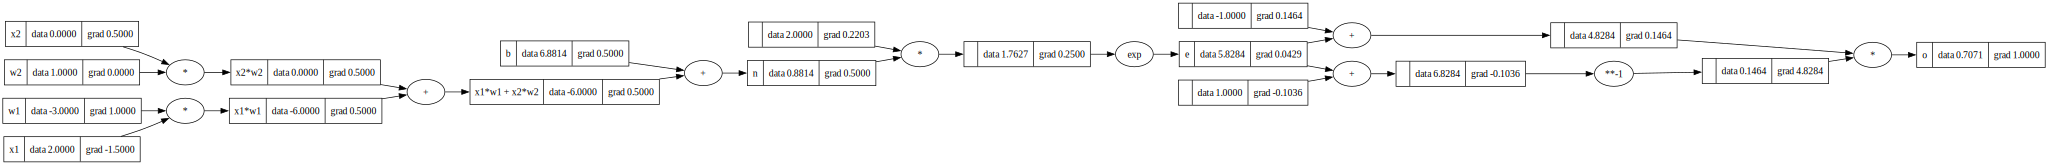

In [165]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the neuron
b = Value(6.8813735870195432, label='b')

# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'

n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'
o.backward()
draw_dot(o)

In [166]:
import torch

In [167]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

# a = torch.Tensor([2.0])
# a.data.item()
# torch can do what micrograd does in a special case
# where all the tensors are single element tensors
# but the big deal is everything is more efficient 
# as we work with these tensor objects where operations can be done in parallel
# neural nets are just a specific class of mathematical functions

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [168]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x): # x is the inputs from previous neurons
        # w * x + b
        assert isinstance(x, list), 'only list allowed'
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self): # we don't make a variable because when the weights change, then the params won't change
        return self.w + [self.b]

class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        # outs2 = [id(n) for n in outs]
        return outs[0] if len(outs) == 1 else outs # assumes we don't have a middle layer of 1 neuron so zip 
        # in line 9 would not work as Value object is not iterable
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()] # same syntax as a nested for loop just return in front


class MLP:

    def __init__(self, nin, nouts): # nouts is a list of all the layers excluding input layer, which is nin
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

13381759296
13448941872
13448941872
13448946240


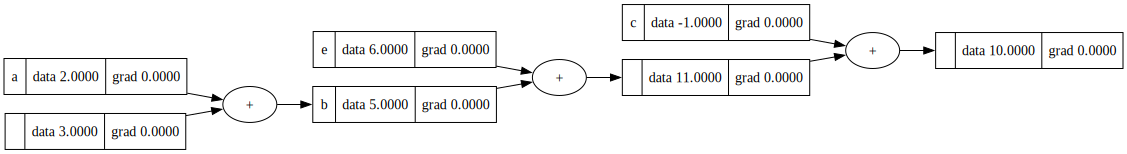

In [120]:
a = Value(2.0); a.label = 'a'
b = Value(3.0)
e = Value(6.0); e.label = 'e'
print(id(b))
b = a + b; b.label = 'b'
b = e + b # vs if i do b = e, then the previous information is lost. 
# this is why in the MLP layers, info isn't lost in memory since it uses x = layer(x), ie it uses it before it reasigns
print(id(b))
print(id(b))
c = Value(-1.0); c.label = 'c'
b = b + c; # when b gets reassigned, does not mean that the b is lost in memory, just that it's pointing to a new object now
print(id(b))
# x.label = 'x'
draw_dot(b)

In [86]:
x = Layer(3, 4)
y = Layer(4, 2)

inputs = [1, 2, 3]
a = x(inputs)
# print(list(id(n) for n in a))

inputs = a
print(inputs)
print('--------')
print(list(id(n) for n in inputs))


[]
--------
[13380767952, 13380776784, 13380765024, 13380156592]


In [169]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [170]:
n = MLP(3, [4, 4, 1])

In [171]:
ypred = [n(x) for x in xs] # the n(x) isn't going to change as it is defined to be the MLP above. it changes if you re-init the MLP
loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
loss # another interesting thing about notebook is that even if the new def for value class, this cell worked because the cell that 
# defined the value objects in ypred and defined how ygt - yout worked for subtraction for it was the old value class in its memory

Value(data=7.704802008873406, grad=0.0)

In [159]:
x = [2, 3, 4]
a = n(x)

print(id(a))
print(id(n(x))) # different objects, not saving this one so it's values do not save
print(id(a))
print('----')
print(a)
print(n(x))
# n(x).backward()
# draw_dot(n(x))

13450361072
13451407056
13450361072
----
Value(data=0.73775957006862, grad=0.0)
Value(data=0.73775957006862, grad=0.0)


In [172]:
# gradient descent
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad # learning rate means step size
        # how much you want to step away from the gradient

    
    print(k, loss.data)


0 7.704802008873406
1 7.44844449477826
2 6.851334594954846
3 4.946050260337427
4 3.095658619833104
5 1.6647935486973342
6 0.6624409901630602
7 0.33748395117114294
8 0.191710914700819
9 0.14311292580146745
10 0.11328718963441964
11 0.0931722363946603
12 0.07876392601753877
13 0.06798003713223331
14 0.059632650155745454
15 0.05299676523108453
16 0.047606079606336275
17 0.043147751269374306
18 0.03940447167733373
19 0.03622082751691375


In [173]:
ypred

[Value(data=0.90089444732515, grad=-0.1982111053497),
 Value(data=-0.9618764420892583, grad=0.07624711582148347),
 Value(data=-0.867412774504445, grad=0.26517445099111003),
 Value(data=0.9141737865594465, grad=-0.17165242688110705)]

# random experimentation

In [16]:
class Value2(Value): 
    def __mul__(self, other): # it does not make sense to return the same value with different grad because...
        self.data *= other

        def _backward():
            self.grad += other * self.grad # 3) the gradients don't just deposit, they get all the intermediaries as well 
        self._backward = _backward
        
        return self

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited: # 1) backward does not allow duplicates
                visited.add(v)
                for child in v._prev: # 2) creates an infinte loop
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

6112697120
id(a),  6112697120
inside function 6112697120
6112697120
id(a),  6112697120
inside function 6112697120
6112697120


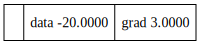

In [17]:
a = Value2(-5.0)
b = Value2(-3.0)
print(id(a))
def f(a):
    print('id(a), ', id(a))
    b = 2*a
    print('inside function', id(b))
    return b
a = f(a)
print(id(a))
a = f(a)
print(id(a))
a.backward()
draw_dot(a)

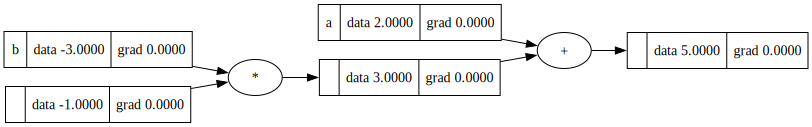

In [175]:
a = Value(2.0); a.label = 'a'
b = Value(-3.0); b.label = 'b'

c = a-b
draw_dot(c)